In [1]:
import albumentations as A
import torch
import os
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
from PIL import Image
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_detection_valid_transform():
    return A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
def get_classification_valid_transform():
    return A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
def predict_unseen_data(classification_model, detection_model, image_path, classification_transform, detection_transform):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    original_image = np.array(image)

    # Classification
    classification_image = classification_transform(image=original_image)['image']
    classification_tensor = classification_image.unsqueeze(0).to(next(classification_model.parameters()).device)

    classification_model.eval()
    with torch.no_grad():
        classification_output = classification_model(classification_tensor)
        predicted_probs = torch.softmax(classification_output, dim=1)
        watermark_prob = predicted_probs[0][1].item()  # Assuming 1 is the watermark class

    # Object Detection
    detection_image = detection_transform(image=original_image, bboxes=[], labels=[])['image']
    detection_tensor = detection_image.unsqueeze(0).to(next(detection_model.parameters()).device)

    detection_model.eval()
    with torch.no_grad():
        detection_output = detection_model(detection_tensor)[0]

    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Original image with classification result
    ax1.imshow(original_image)
    ax1.set_title(f'Classification: {"Watermark" if watermark_prob > 0.5 else "No Watermark"}\nProbability: {watermark_prob:.4f}')
    ax1.axis('off')

    # Image with bounding boxes
    ax2.imshow(original_image)
    height, width = original_image.shape[:2]
    for box, score, label in zip(detection_output['boxes'].cpu(), detection_output['scores'].cpu(), detection_output['labels'].cpu()):
        if score > 0.3:  # Lowered threshold for visualization
            box = box.numpy()
            # Scale the box coordinates to match the original image size
            x1, y1, x2, y2 = box
            x1 = int(x1 * width / 224)
            y1 = int(y1 * height / 224)
            x2 = int(x2 * width / 224)
            y2 = int(y2 * height / 224)

            label_name = "r123" if label.item() == 1 else "non_r123"
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax2.add_patch(rect)
            ax2.text(x1, y1, f'{label_name}: {score.item():.2f}', color='red', fontsize=8,
                     bbox=dict(facecolor='white', alpha=0.5))
    ax2.set_title('Object Detection')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return watermark_prob, detection_output
def get_object_detection_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
def load_model(model, model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model


class WatermarkClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(WatermarkClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features

        # Remove the last fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        # Add new layers
        self.fc1 = nn.Linear(num_ftrs, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

classification_model_path = '/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/models/classification_models/best_classification_model.pth'
detection_model_path = '/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/models/object_detection_models/final_model.pth'

classification_model = load_model(WatermarkClassifier(), classification_model_path, device)
detection_model = load_model(get_object_detection_model(num_classes=2), detection_model_path, device)

/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/dr/ws9cv98n2h108c3cntr42tb40000gn/T/ipykernel_30711/3887277087.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct 

Prediction on Unseen Data:


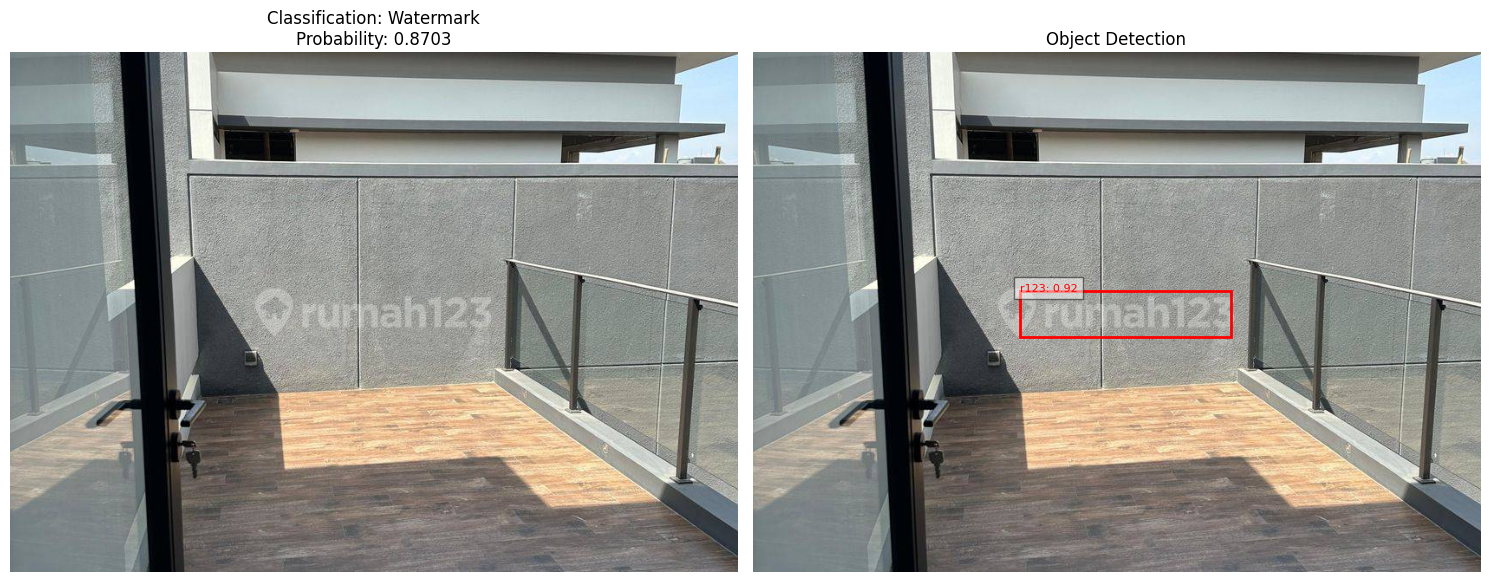

Image Classification Result:
  Watermark Probability: 0.8703
  Prediction: R123 Watermark

Object Detection Results:
  Detected Objects: 1 (scores > 0.5)
  Top 5 detections:
    1. r123: 0.9216


In [2]:
classification_transform = get_classification_valid_transform()
detection_transform = get_detection_valid_transform()

unseen_image_path = '/Users/driandy/Desktop/Works/Personal/99 group/watermark_detection/data/all_data/7MGGDBSEUVldXdqP.jpg'

print("Prediction on Unseen Data:")
watermark_prob, detection_prediction = predict_unseen_data(classification_model, detection_model, unseen_image_path, classification_transform, detection_transform)

print(f"Image Classification Result:")
print(f"  Watermark Probability: {watermark_prob:.4f}")
print(f"  Prediction: {'R123 Watermark' if watermark_prob > 0.5 else 'No R123 Watermark'}")

print("\nObject Detection Results:")
r123_detections = [(score.item(), label.item()) for score, label in zip(detection_prediction['scores'], detection_prediction['labels']) if score > 0.5]
print(f"  Detected Objects: {len(r123_detections)} (scores > 0.5)")
print("  Top 5 detections:")
for i, (score, label) in enumerate(sorted(r123_detections, reverse=True)[:5], 1):
    label_name = "r123" if label == 1 else "non_r123"
    print(f"    {i}. {label_name}: {score:.4f}")